In [2]:
from torchvision import models, transforms , utils
import torch
import numpy as np
import os
import pathlib
import PIL
from tqdm import tqdm
from ipywidgets import IntProgress
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report ,roc_curve
from torch.autograd import Variable
from sklearn.metrics import auc
from skorch import NeuralNetClassifier
from modAL.models import ActiveLearner

### Dataloader

In [2]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

class CheckBoxDataset(torch.utils.data.Dataset):
    """Checkbox dataset."""
    def __init__(self, root_dir: pathlib.Path, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """    
        self.paths = []

        self.folder_labels = {"empty": 0, "filled": 1, "no-checkbox": 2}

        for sub_dir in self.folder_labels.keys():
            cur_dir = root_dir / sub_dir
            for file in cur_dir.glob("*.png"):
                self.paths.append(file)
                
        classes, class_to_idx = find_classes(root_dir)  
        self.classes = classes
        self.class_to_idx = class_to_idx
                                  
        self.transform = transform
        assert self.paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.paths[idx]    
        label = self.folder_labels[str(self.paths[idx].parent).rsplit("\\",1)[-1]]
        image = PIL.Image.open(img_name)
        
        if image.mode != "RGB":
            image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)    
        else:
            image = transforms.ToTensor()(image)  
        
        return image, label 

In [3]:
batch_size = 8
num_workers = 0
shuffle = True
lr = 3e-4
epochs = 10
device = torch.device("cuda")
mean = [0.8372, 0.8372, 0.8375]
std = [0.2755, 0.2757, 0.2748]
drop_out = 0.3
n_output = 3
size = (64,64)

In [4]:
training_data = pathlib.Path("D:/Code/Python/Checkbox/checkbox_data_021120/train/")
test_data = pathlib.Path("D:/Code/Python/Checkbox/checkbox_data_021120/test/")

In [5]:
train_pipelines = transforms.Compose([transforms.Resize(size=size),
                                      transforms.RandomRotation(degrees=90),
                                      transforms.ColorJitter(brightness=0.9, contrast=0.5, saturation=0.9, hue=0.5),
                                      transforms.RandomGrayscale(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

test_pipelines = transforms.Compose([transforms.Resize(size=size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mean,std=std)])

In [6]:
train_dataset = CheckBoxDataset(training_data, transform=train_pipelines)
test_dataset = CheckBoxDataset(test_data, transform=test_pipelines)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size= 21580,#Load all data
                                           num_workers=num_workers,
                                           shuffle=shuffle)

In [8]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size= 9911,
                                          num_workers=num_workers)

In [9]:
import numpy as np




X, y = next(iter(train_loader))
xtest ,ytest = next(iter(test_loader))



In [10]:
# read training data
#converting tensor to numpy
X_train = X.reshape(21580, 3, 64, 64).numpy()
X_test = xtest.reshape(9911, 3, 64, 64).numpy()
y_train = y[:21580].numpy()
y_test = ytest[:9911].numpy()



#### Initial data set selection

In [11]:
initial_idx = np.array([],dtype=np.int)
for i in range(3):
    idx = np.random.choice(np.where(y_train==i)[0], size=10, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

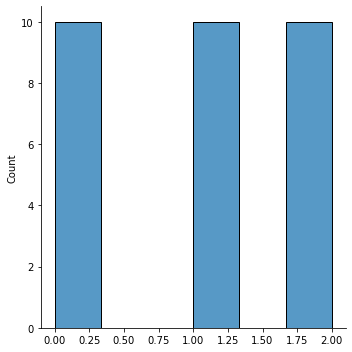

In [12]:

#Checking data distribution

sns.displot(y_initial)



In [13]:
#deleting initial data rom the pool set
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [179]:
# optional-assemble initial data random choice without balance
n_initial = 10
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]



In [14]:
class CheckBoxClassifier(torch.nn.Module):
    def __init__(self, n_output, drop_out):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,
                                                                     out_channels=8,
                                                                     kernel_size=3,
                                                                     stride=2,
                                                                     padding=1,
                                                                     bias=True),
                                                     torch.nn.ReLU(inplace=True),
                                                     torch.nn.Conv2d(in_channels=8,
                                                                     out_channels=64,
                                                                     kernel_size=3,
                                                                     stride=2,
                                                                     padding=1,
                                                                     bias=True),
                                                     torch.nn.ReLU(inplace=True))
                                                    
                                                    
        
                                                     
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2)
        self.flatten = torch.nn.Flatten()
        self.dropout1 = torch.nn.Dropout(p=0.3)

        self.classifier = torch.nn.Sequential(torch.nn.Linear(4096,256),
                                              torch.nn.ReLU(inplace=True),
                                              torch.nn.Dropout(p=0.3),
                                              torch.nn.Linear(256,n_output),
                                              torch.nn.Softmax(dim=1))
        
    def forward(self,x):
        x = self.feature_extractor(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.classifier(x)
        return x 

original_model = models.resnet50(pretrained=True)
class Resnet(torch.nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.feature_extractor = torch.nn.Sequential(*list(original_model.children())[:-1])
        
        self.classifier= torch.nn.Sequential(torch.nn.Dropout(p=0.7),
                                              torch.nn.Linear(2048,256),
                                              torch.nn.ReLU(inplace=True),
                                              torch.nn.Dropout(p=0.7),
                                              torch.nn.Linear(256,3),
                                              torch.nn.Softmax(dim=1))
       
                
    def forward(self, x):
        x = self.feature_extractor(x)
        x=x.view(-1,2048)
        x = self.classifier(x)
        return x   



  


In [36]:
model = CheckBoxClassifier(n_output=n_output, drop_out=drop_out)
#model=Resnet()
model



CheckBoxClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (dropout1): Dropout(p=0.5, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
    (4): Softmax(dim=1)
  )
)

In [17]:
#Random sampling
def uniform(learner, X, n_instances=1): #n_instance is no of informative samples selected at a time
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    return query_idx, X[query_idx]

In [16]:
#active learning workflow
#n_queries= no of times repeating the selection of n_instances
#query strategy and model is passed
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=100,
                              n_instances=10):
    
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    
    perf_hist = [learner.score(X_test, y_test)]
    times_per_iteration = []
    
    for index in range(n_queries):
        torch.cuda.synchronize()  # wait for move to complete
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)
        torch.cuda.synchronize()  
        end.record()
        torch.cuda.synchronize()  # need to wait once more for op to finish
        times_per_iteration.append(start.elapsed_time(end))
    return perf_hist,times_per_iteration,learner


### Active learning loop

In [ ]:
#random sampling training
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(model,
                                max_epochs=50,
                                batch_size=8,
                                lr= 3e-4,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
uniform_perf_hist,times_per_iteration,modified_learner = active_learning_procedure(uniform,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

In [17]:
def max_entropy(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=500, replace=False)
    score_All = np.zeros(shape=(random_subset.shape[0], 3))
    with torch.no_grad():
        for t in range(100):
            outputs = learner.estimator.forward(X[random_subset], training=True).cpu().numpy()
            score_All = score_All + outputs

    Avg_Pi = np.divide(score_All,100)# prob over T iterations
    Log_Avg_Pi = np.log2(Avg_Pi+ 1e-10)
    Entropy_Avg_Pi = - np.multiply(Avg_Pi, Log_Avg_Pi)# entropy
    Entropy_Average_Pi = np.sum(Entropy_Avg_Pi, axis=1)# average entropy

    U_X = Entropy_Average_Pi                
        
    
    a_1d = U_X.flatten()
    idx = a_1d.argsort()[-n_instances:][::-1]# select last 10 instances
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

    



In [ ]:
#entropy training
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(model,
                                max_epochs=50,
                                batch_size=8,
                                lr=3e-4,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
entropy_perf_hist,times_per_iteration,modified_learner = active_learning_procedure(max_entropy,
                                              X_test,
                                              y_test,
                                              X_pool,
                                              y_pool,
                                              X_initial,
                                              y_initial,
                                              estimator,)

In [20]:
import pickle
filename="entropycheckboxexp3.sav"
pickle.dump(modified_learner,open(filename,'wb'))


C:\Users\ANANYA\Anaconda3\envs\pybcnn\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CheckBoxClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ANANYA\Anaconda3\envs\pybcnn\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [21]:
import pickle
filename= "entropycheckboxexp3.sav"
loaded_model=pickle.load(open(filename,'rb'))
result=loaded_model.score(X_test, y_test)
print(result)

0.8942589042478055


In [22]:
predicted = loaded_model.predict(X_test)
conf_mat = confusion_matrix(y_test, predicted)
print(conf_mat)

[[7929  824   38]
 [  90  795   16]
 [  42   38  139]]


In [23]:
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8791
           1       0.48      0.88      0.62       901
           2       0.72      0.63      0.67       219

    accuracy                           0.89      9911
   macro avg       0.73      0.81      0.75      9911
weighted avg       0.93      0.89      0.91      9911



[90.19451712 88.23529412 63.47031963]


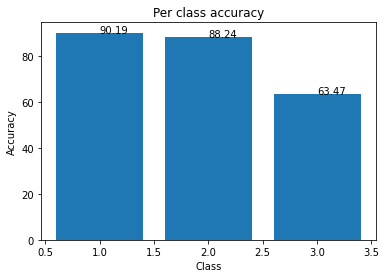

In [24]:
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
import matplotlib.pyplot as plt

y = np.round(class_accuracy,2)
x=[1,2,3]

plt.bar(x,y)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per class accuracy")
for a,b in zip(x, y): 
    plt.text(a, b, str(b))
plt.show()

Max Accuracy : 0.9404701846433255
Total time taken (in Mins) =  58.88


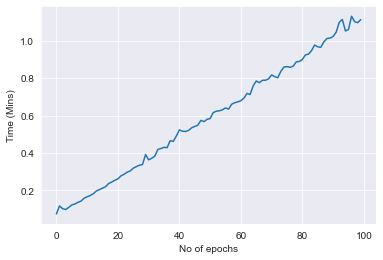

In [25]:
print("Max Accuracy :",max(uniform_perf_hist))
%matplotlib inline
sns.set_style('darkgrid')
times_per_iteration1=[]
times_per_iteration1[:] = [x / 100000 for x in times_per_iteration]

plt.plot(range(0,100),times_per_iteration1)
plt.xlabel("No of epochs")
plt.ylabel("Time (Mins)")
print("Total time taken (in Mins) = ",round(sum(times_per_iteration1),2))

In [26]:
np.save('timetaken_randomcheckboxexp3.npy',times_per_iteration1)
np.save('Accuracy_randomcheckboxexp3.npy',uniform_perf_hist)

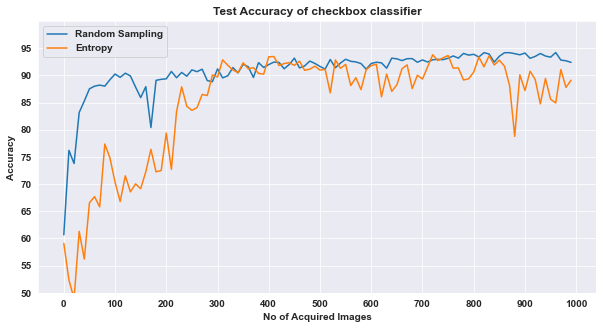

In [3]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
sns.set_style('darkgrid')


plt.rcParams["font.weight"]="bold"
plt.rcParams["axes.labelweight"]="bold"

plt.figure(figsize=(10,5))
b2= np.load('./Entropy/Checkbox/Selected/Average_entropycheckbox.npy')  
b1= np.load('./RandomSampling1/Checkbox/Selected/Average_randomcheckbox.npy')
x= np.arange(0,1000,10)
y= b1[1:101]
w=np.arange(0,1000,10)
v= b2[1:101]
plt.plot(x,y*100,label='Random Sampling')
plt.plot(w,v*100,label='Entropy')


plt.xlabel('No of Acquired Images', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(50, 1*100)


plt.yticks(np.arange(50,100, 5))
plt.xticks(np.arange(0,1001, 100))
plt.title("Test Accuracy of checkbox classifier",fontweight='bold')
plt.legend()

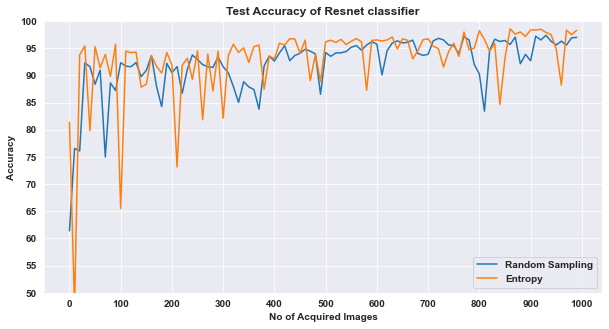

In [6]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
sns.set_style('darkgrid')

plt.rcParams["font.weight"]="bold"
plt.rcParams["axes.labelweight"]="bold"

plt.figure(figsize=(10,5))
  
b2= np.load('./Entropy/Resnet/Average_entropyresnet.npy')
b1= np.load('./RandomSampling1/Resnet/Selected/Average_randomresnet.npy')

x= np.arange(0,1000,10)
y= b1[1:101]
w=np.arange(0,1000,10)
v= b2[1:101]
plt.plot(x,y*100,label='Random Sampling')
plt.plot(w,v*100,label='Entropy')



plt.xlabel('No of Acquired Images', fontweight='bold')
plt.ylabel('Accuracy',fontweight='bold')
plt.ylim(50, 1*100)

plt.xticks(np.arange(0,1001, 100))

plt.yticks(np.arange(50,101, 5))
plt.title("Test Accuracy of Resnet classifier", fontweight='bold')
plt.legend()